# Principle Component Analysis Dimensionality Reduction

There could be many, many features that impact whether a stock price goes up or down. Predicting directionality for stocks, the VIX, commodities, FX etc represents a huge potential gain for every small percentage increment in forecast ability.

However, having so many features allows room for noise and can create adverse impacts to your supervised learning. Therefore, we will explore deplying PCA (Principle Component Analysis) as a tool to find useful information within a vast array of indicators and features to help with our supervised learning later on.

### Imports

In [1]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Data Management
import pandas as pd
import numpy as np
from ta import add_all_ta_features
import datetime
from pandas_datareader import data as pdr
import yfinance as yf
# yfin.pdr_override()
np.random.seed(42)

# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score


# Reporting
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\andre\anaconda3\envs\env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Initial Data Extraction

In [2]:
# Data Extraction
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=3650)

symbol = "SPY"
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Add TA
df = add_all_ta_features(df, open='Open', high='High', low='Low', close='Adj Close', volume='Volume', fillna=True)
constant_columns = [col for col in df.columns if df[col].nunique() == 1]

### Data Preprocessing

In [4]:
# Identify constant value columns
constant_columns = [col for col in df.columns if df[col].nunique() == 1]

# Print or handle the constant columns
if constant_columns:
    print(f"Columns with constant values: {constant_columns}")
else:
    print("No columns have constant values.")

No columns have constant values.


In [5]:
# Drop constant value columns
constant_columns = [col for col in df.columns if df[col].nunique() == 1]

# Drop columns with constant values from the DataFrame
df = df.drop(columns=constant_columns)

In [6]:
# Identify non-stationary features
non_stationaries = []
for col in df.columns[1:]:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]['1%']
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 39


In [7]:
# Convert non-stationaries to stationary
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [8]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [9]:
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
print(df_stationary.head())

                  Open      High       Low     Close  Adj Close     Volume  \
Date                                                                         
2014-08-14  195.160004  0.003589  0.005259  0.004722   0.004722   57371000   
2014-08-15  196.470001  0.004546 -0.003436 -0.000204  -0.000205  139951000   
2014-08-18  196.800003  0.004068  0.012248  0.008379   0.008380   75424000   
2014-08-19  197.839996  0.005520  0.003813  0.005219   0.005219   59135000   
2014-08-20  198.119995  0.003123  0.003241  0.002671   0.002671   72763000   

              volume_adi  volume_obv  volume_cmf     volume_fi  ...  \
Date                                                            ...   
2014-08-14 -8.581478e+09    0.830898    0.188010  4.417942e+07  ...   
2014-08-15 -1.236850e+10   -1.107050   -0.315962  3.719783e+07  ...   
2014-08-18 -1.869561e+10   -5.573339    0.177995  4.667495e+07  ...   
2014-08-19 -2.212922e+10    0.955470    0.009074  4.729005e+07  ...   
2014-08-20 -2.645743e+10   

In [10]:
# Identify non-stationary features
non_stationaries = []
for col in df_stationary.columns[1:]:
    dftest = adfuller(df_stationary[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]['1%']
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 1


### Scaling & Target Setting

In [11]:
# Set Target
df_stationary['TARGET'] = 0
df_stationary.loc[df_stationary['Adj Close'].shift(-1) > df_stationary['Adj Close'], 'TARGET'] = 1
df_stationary.dropna(inplace=True)

In [12]:
df_stationary.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2014-08-14,195.160004,0.003589,0.005259,0.004722,0.004722,57371000,-8.581478e+09,0.830898,0.188010,4.417942e+07,...,0.007531,0.030124,-1.366075,-0.273215,-1.092860,0.002176,0.472190,0.471079,0.000000,0
2014-08-15,196.470001,0.004546,-0.003436,-0.000204,-0.000205,139951000,-1.236850e+10,-1.107050,-0.315962,3.719783e+07,...,0.019038,0.046029,6.717201,1.124868,5.592332,0.001122,-0.020459,-0.020462,-0.043533,1
2014-08-18,196.800003,0.004068,0.012248,0.008379,0.008380,75424000,-1.869561e+10,-5.573339,0.177995,4.667495e+07,...,0.045786,0.106991,5.881376,2.076170,3.805206,0.004387,0.837956,0.834464,1.863766,0
2014-08-19,197.839996,0.005520,0.003813,0.005219,0.005219,59135000,-2.212922e+10,0.955470,0.009074,4.729005e+07,...,0.088945,0.172637,3.455601,2.352056,1.103545,0.004503,0.521878,0.520521,0.408720,0
2014-08-20,198.119995,0.003123,0.003241,0.002671,0.002671,72763000,-2.645743e+10,0.601218,0.011935,4.514546e+07,...,0.144185,0.220958,2.944986,2.470642,0.474344,0.003416,0.267142,0.266786,0.149292,1


In [13]:
# Split Target from Features
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [14]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [15]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

### PCA Dimensionality Reduction

In [16]:
n_components = 15
pca = PCA(n_components=n_components)
pca_result = pca.fit(X_train)
X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

In [17]:
# Calculate the variance explained by Principal Components
print("Variance of each component:", pca.explained_variance_ratio_)
print("\n Total Variance Explained:", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

Variance of each component: [0.30231789 0.10721743 0.07854913 0.06220271 0.04463389 0.04087085
 0.02795443 0.02667983 0.02207466 0.0207459  0.01860435 0.0181535
 0.01675076 0.01619451 0.01325941]

 Total Variance Explained: 81.62


Utilizing 15 PCA components, we capture 87% of the total variance.

In [18]:
# Print variance of each component
variance_ratios = pca.explained_variance_ratio_
print("Variance of each component:")
for i, variance in enumerate(variance_ratios, start=1):
    print(f"Component {i}: {variance:.4f}")

# Print total variance explained
total_variance_explained = round(sum(variance_ratios) * 100, 2)
print("\nTotal Variance Explained: {}%".format(total_variance_explained))

Variance of each component:
Component 1: 0.3023
Component 2: 0.1072
Component 3: 0.0785
Component 4: 0.0622
Component 5: 0.0446
Component 6: 0.0409
Component 7: 0.0280
Component 8: 0.0267
Component 9: 0.0221
Component 10: 0.0207
Component 11: 0.0186
Component 12: 0.0182
Component 13: 0.0168
Component 14: 0.0162
Component 15: 0.0133

Total Variance Explained: 81.62%


### Visualizations

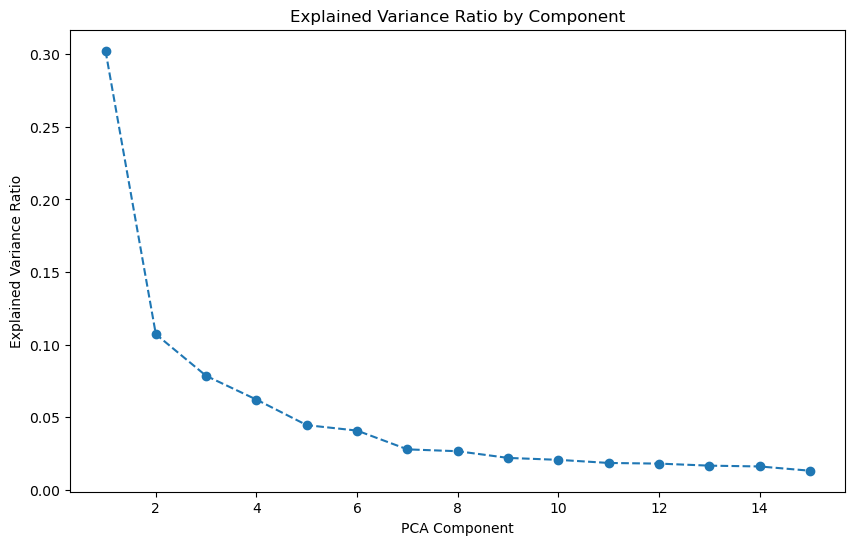

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Component')
plt.show()

This plot illustrates the explained variance ratio by component. We observe that the explained variance ratio begins to level off at approximately 2% to 4% after the sixth PCA component.

In [20]:
# Create columns
pca_cols = []
for i in range(n_components):
    pca_cols.append(f'PC_{i}')

df_pca = pd.DataFrame(data=X_train_pca, columns=pca_cols)

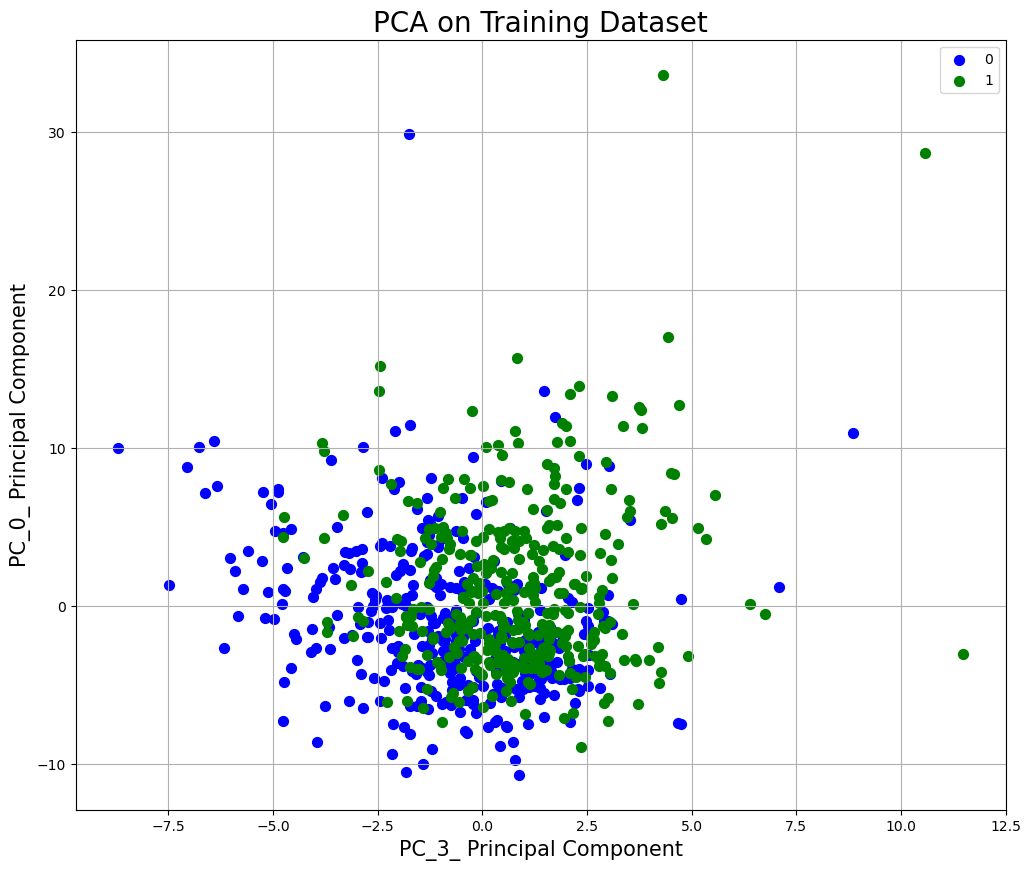

In [29]:
# Visualize Principal Components with Scatter PLot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
col_1 = 'PC_3'
col_2 = 'PC_0'
ax.set_xlabel(f'{col_1}_ Principal Component', fontsize=15)
ax.set_ylabel(f'{col_2}_ Principal Component', fontsize=15)
ax.set_title('PCA on Training Dataset', fontsize=20)

targets = [0, 1]
colors = ['b', 'g']
for target, color in zip(targets, colors):
    indices_to_keep = y_train == target
    indices_to_keep = list(indices_to_keep)
    ax.scatter(df_pca.loc[indices_to_keep, col_1],
               df_pca.loc[indices_to_keep, col_2],
               c=color,
               s=50)
ax.legend(targets)
ax.grid()
plt.show()

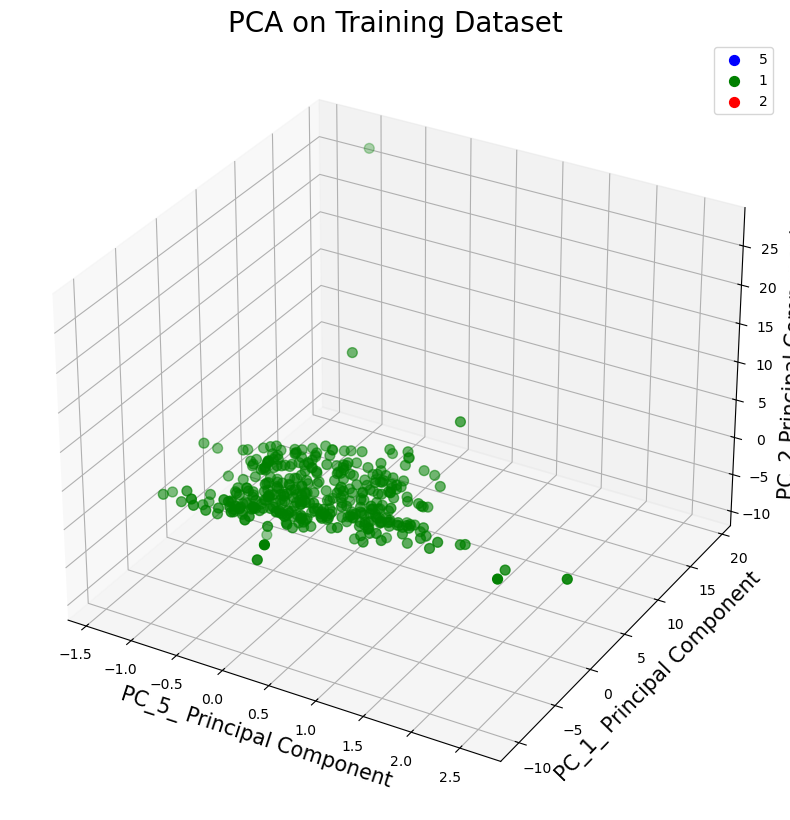

In [22]:
# Visualize Principal Components with Scatter PLot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
col_1 = 'PC_5'
col_2 = 'PC_1'
col_3 = 'PC_2'
ax.set_xlabel(f'{col_1}_ Principal Component', fontsize=15)
ax.set_ylabel(f'{col_2}_ Principal Component', fontsize=15)
ax.set_zlabel(f'{col_3} Principal Component', fontsize=15)
ax.set_title('PCA on Training Dataset', fontsize=20)

targets = [5, 1, 2]
colors = ['b', 'g', 'r']
for target, color in zip(targets, colors):
    indices_to_keep = y_train == target
    indices_to_keep = list(indices_to_keep)
    ax.scatter(df_pca.loc[indices_to_keep, col_1],
               df_pca.loc[indices_to_keep, col_2],
               df_pca.loc[indices_to_keep, col_3],
               c=color,
               s=50)
ax.legend(targets)
ax.grid()
plt.show()

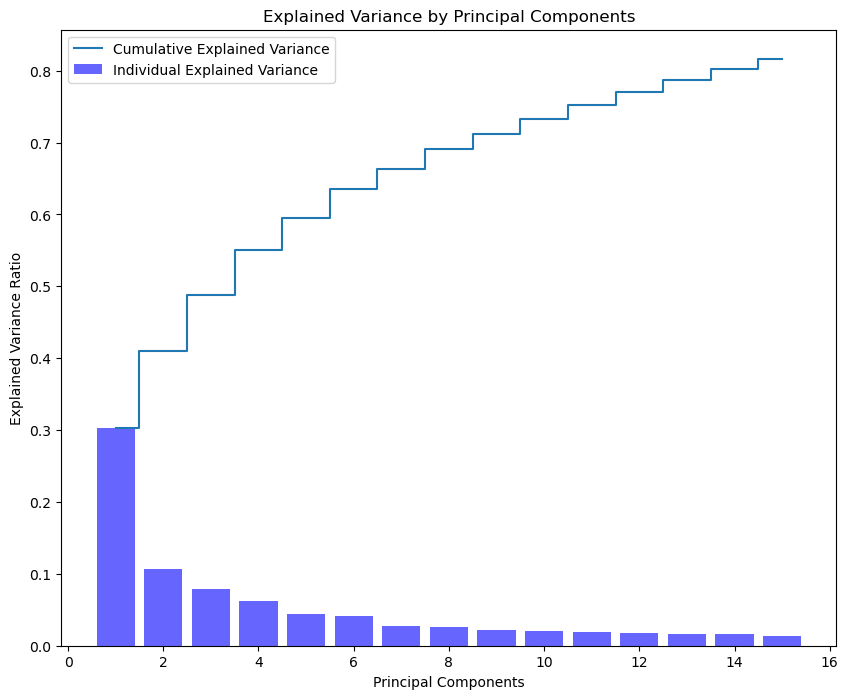

In [23]:
# Explained Variance Plot
plt.figure(figsize=(10, 8))
plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, alpha=0.6, color='b', label='Individual Explained Variance')
plt.step(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()

This plot shows the explained variance of each individual component along with the cumulative explained variance.

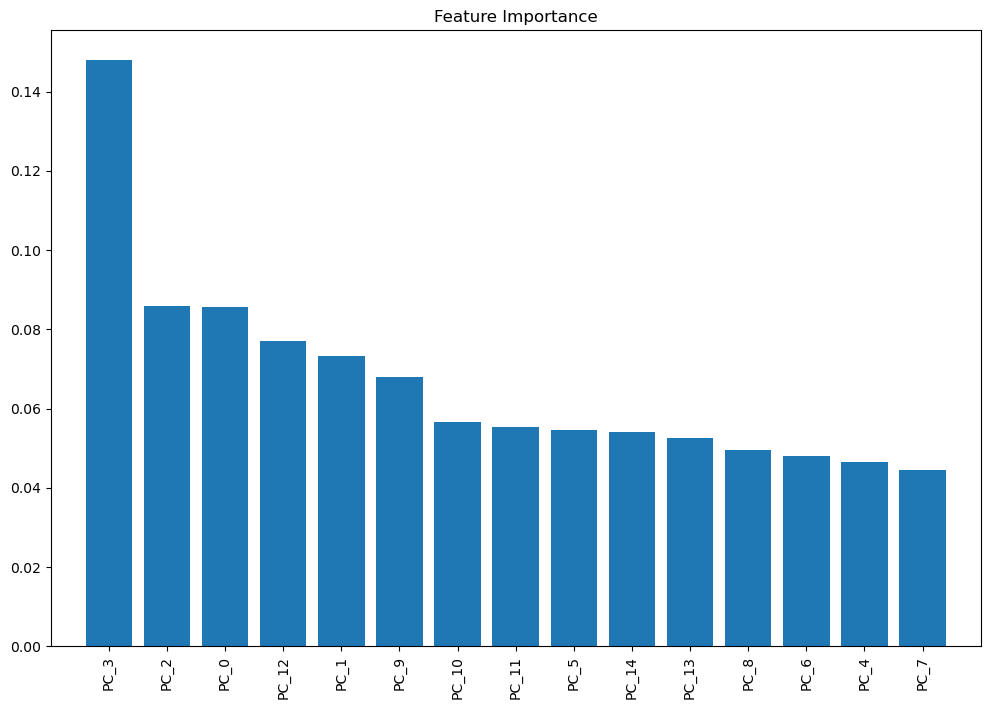

In [24]:
# Feature Importance from Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.bar(range(X_train_pca.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_pca.shape[1]), [pca_cols[i] for i in indices], rotation=90)
plt.xlim([-1, X_train_pca.shape[1]])
plt.show()

This plot displays the feature importance determined by the Random Forest model, highlighting which features the model deemed most significant. Similar to the explained variance, the feature importance begins to level off after the sixth component.

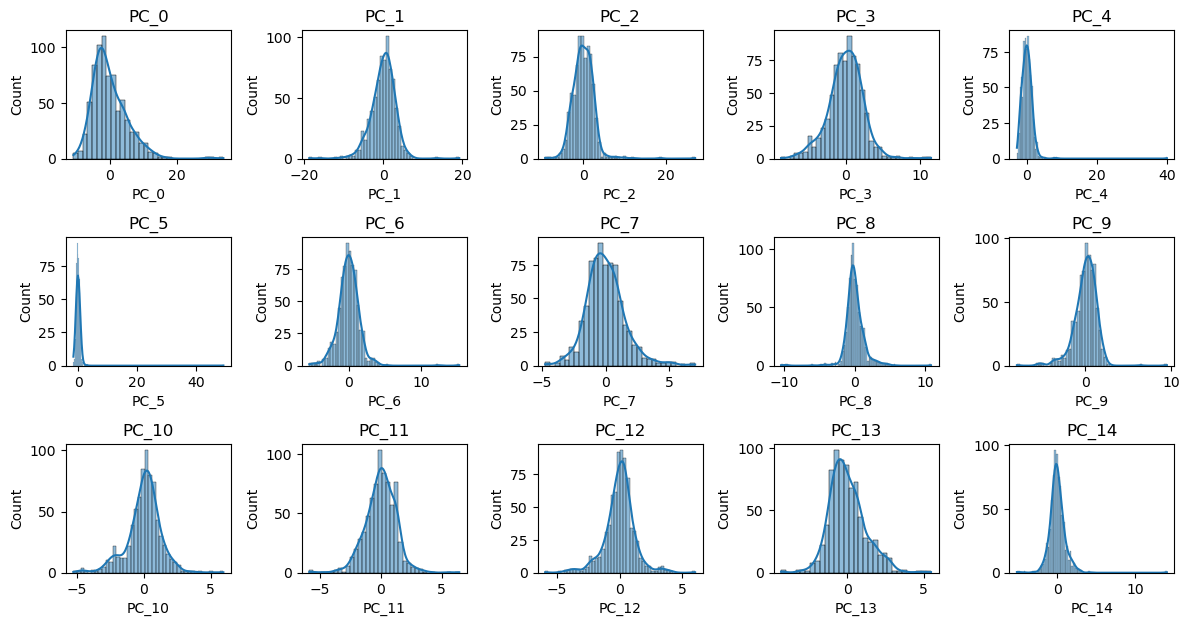

In [25]:
# PCA Components Distribution
plt.figure(figsize=(12, 8))
for i in range(n_components):
    plt.subplot(4, 5, i + 1)
    sns.histplot(df_pca[f'PC_{i}'], kde=True)
    plt.title(f'PC_{i}')
plt.tight_layout()
plt.show()

Here we analyze the distributions of the PCA components.  The histograms along with the Kernel Density plots allows us to visualize the distribution of the values to gain an understanding of the overall shape and density.  This helps us to see the spread, central tendency, and any skewness in the data.  We can assess whether the distributions are approximately normal (bell-shaped). Many PCA components are often approximately normally distributed due to the central limit theorem, but deviations from normality can give insights into the data structure.  A skewed distribution indicates that the data is not symmetrically distributed around the mean, which can affect the interpretability of the PCA components.  High kurtosis suggests outliers, while low kurtosis indicates a more uniform distribution.  Outliers in PCA components can significantly influence the direction of the components, potentially skewing the results.  Components with low variance might have distributions concentrated around zero, indicating less importance in capturing the overall data structure.  We can compare the distributions of different components to see if they have similar spreads or if some components capture more spread (variability) in the data. Components with wider distributions often capture more of the variance.  We can check if any component has a bi-modal or multi-modal distribution, which could indicate the presence of distinct subgroups or clusters within the data.